In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

from fastai import *
from fastai.vision import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from superRes.metrics import *

import torchvision
import geffnet # efficient/ mobile net

In [2]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=20)

In [13]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_512 = path/'DIV2K_train_LR_512_QF50'

proj_id = 'unet_superRes_mobilenetV3_LPIPS_Tuned'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [4]:
model = geffnet.mobilenetv3_rw

In [5]:
loss_func = lpips_loss()

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [8]:
bs=1
sz=512
lr = 1e-2
wd = 1e-3
epochs = 1

In [9]:
data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

In [10]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [11]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

In [12]:
learn_gen.load("/data/students_home/fmameli/repos/SuperRes/dataset/DIV2K_train_LR_Patches/64px_FullQF20/models/unet_superRes_mobilenetV3_Patches64px_gen_64px_2")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF50;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF50;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

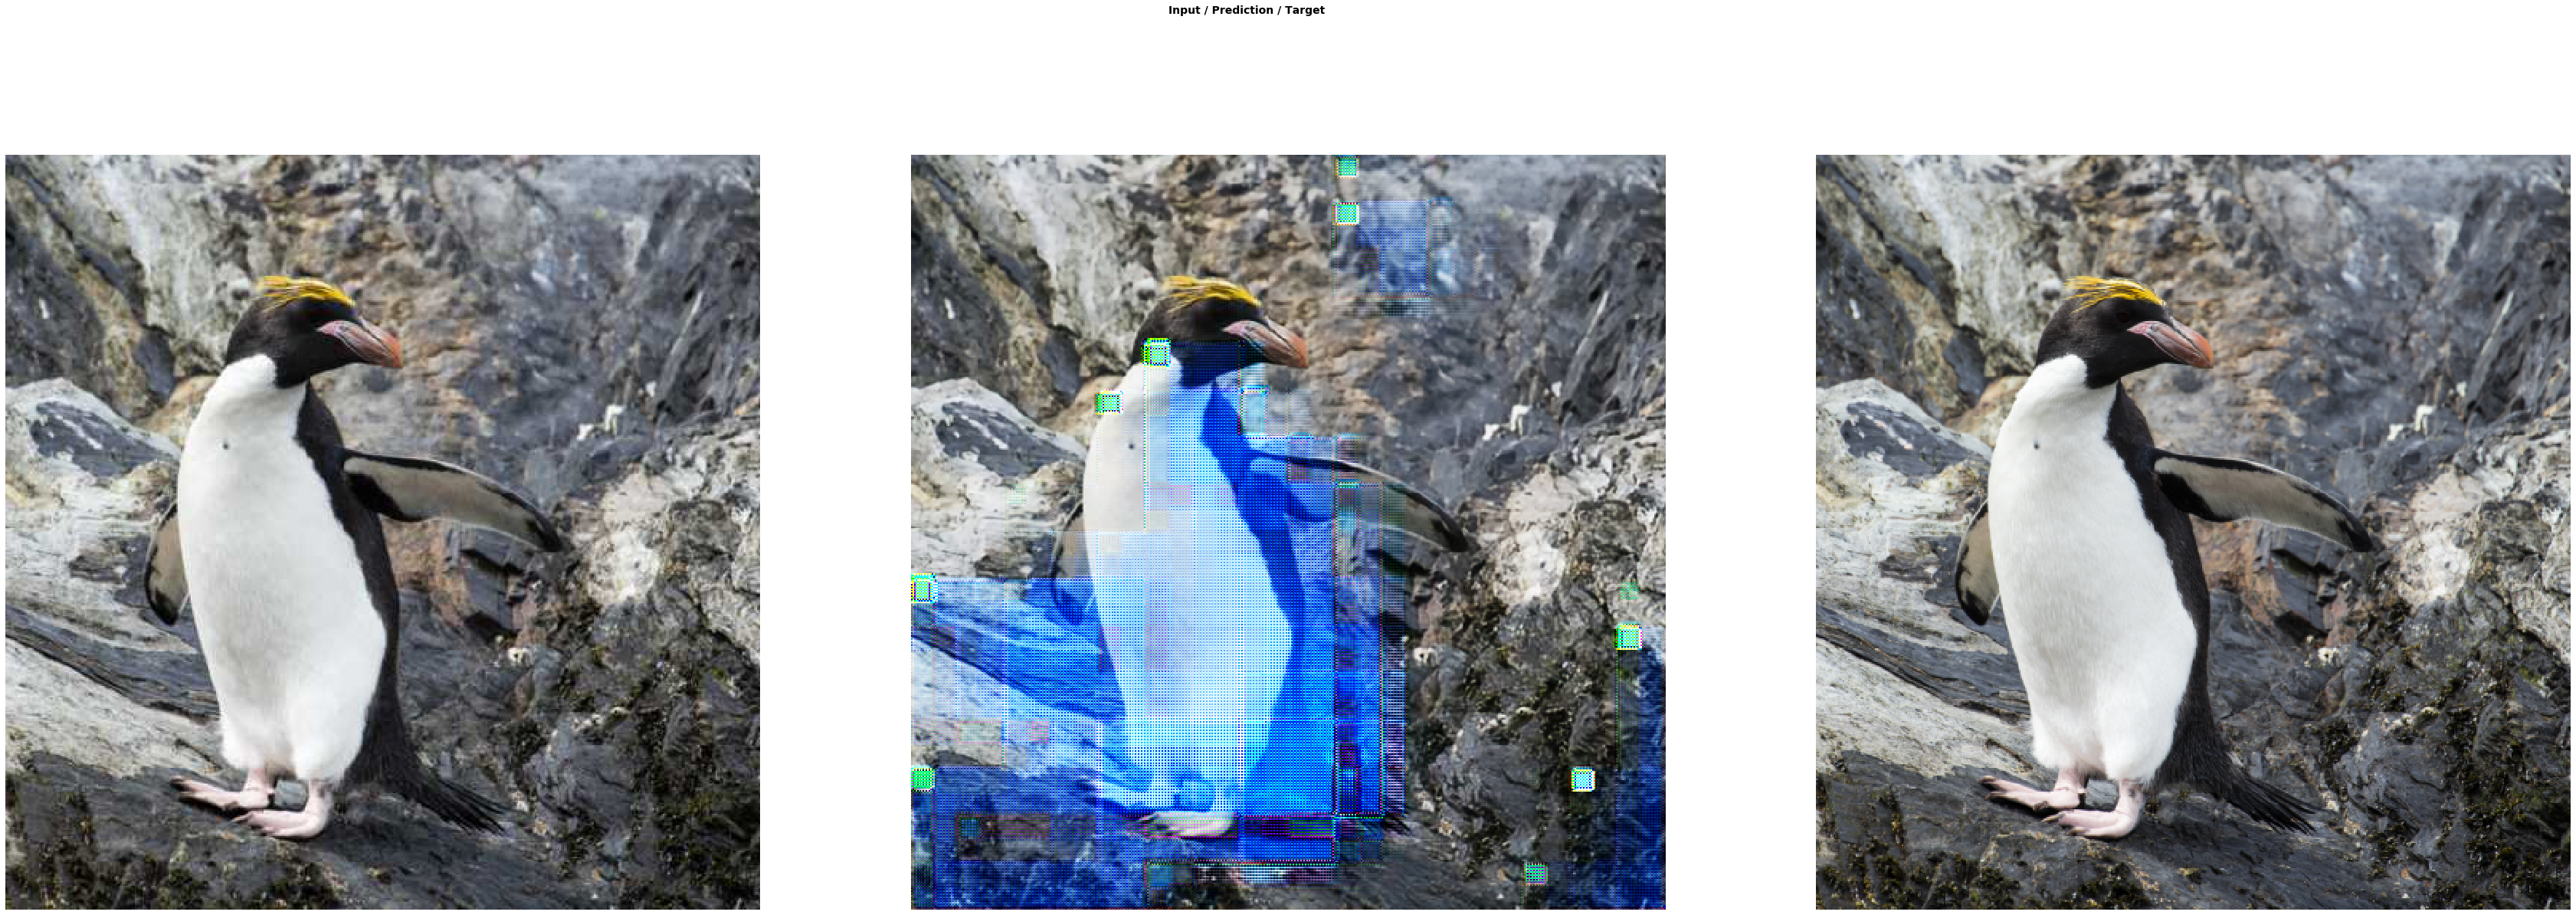

In [14]:
do_fit(learn_gen, 1, gen_name+"_512px_5", 1e-3)

In [15]:
learn_gen.unfreeze()

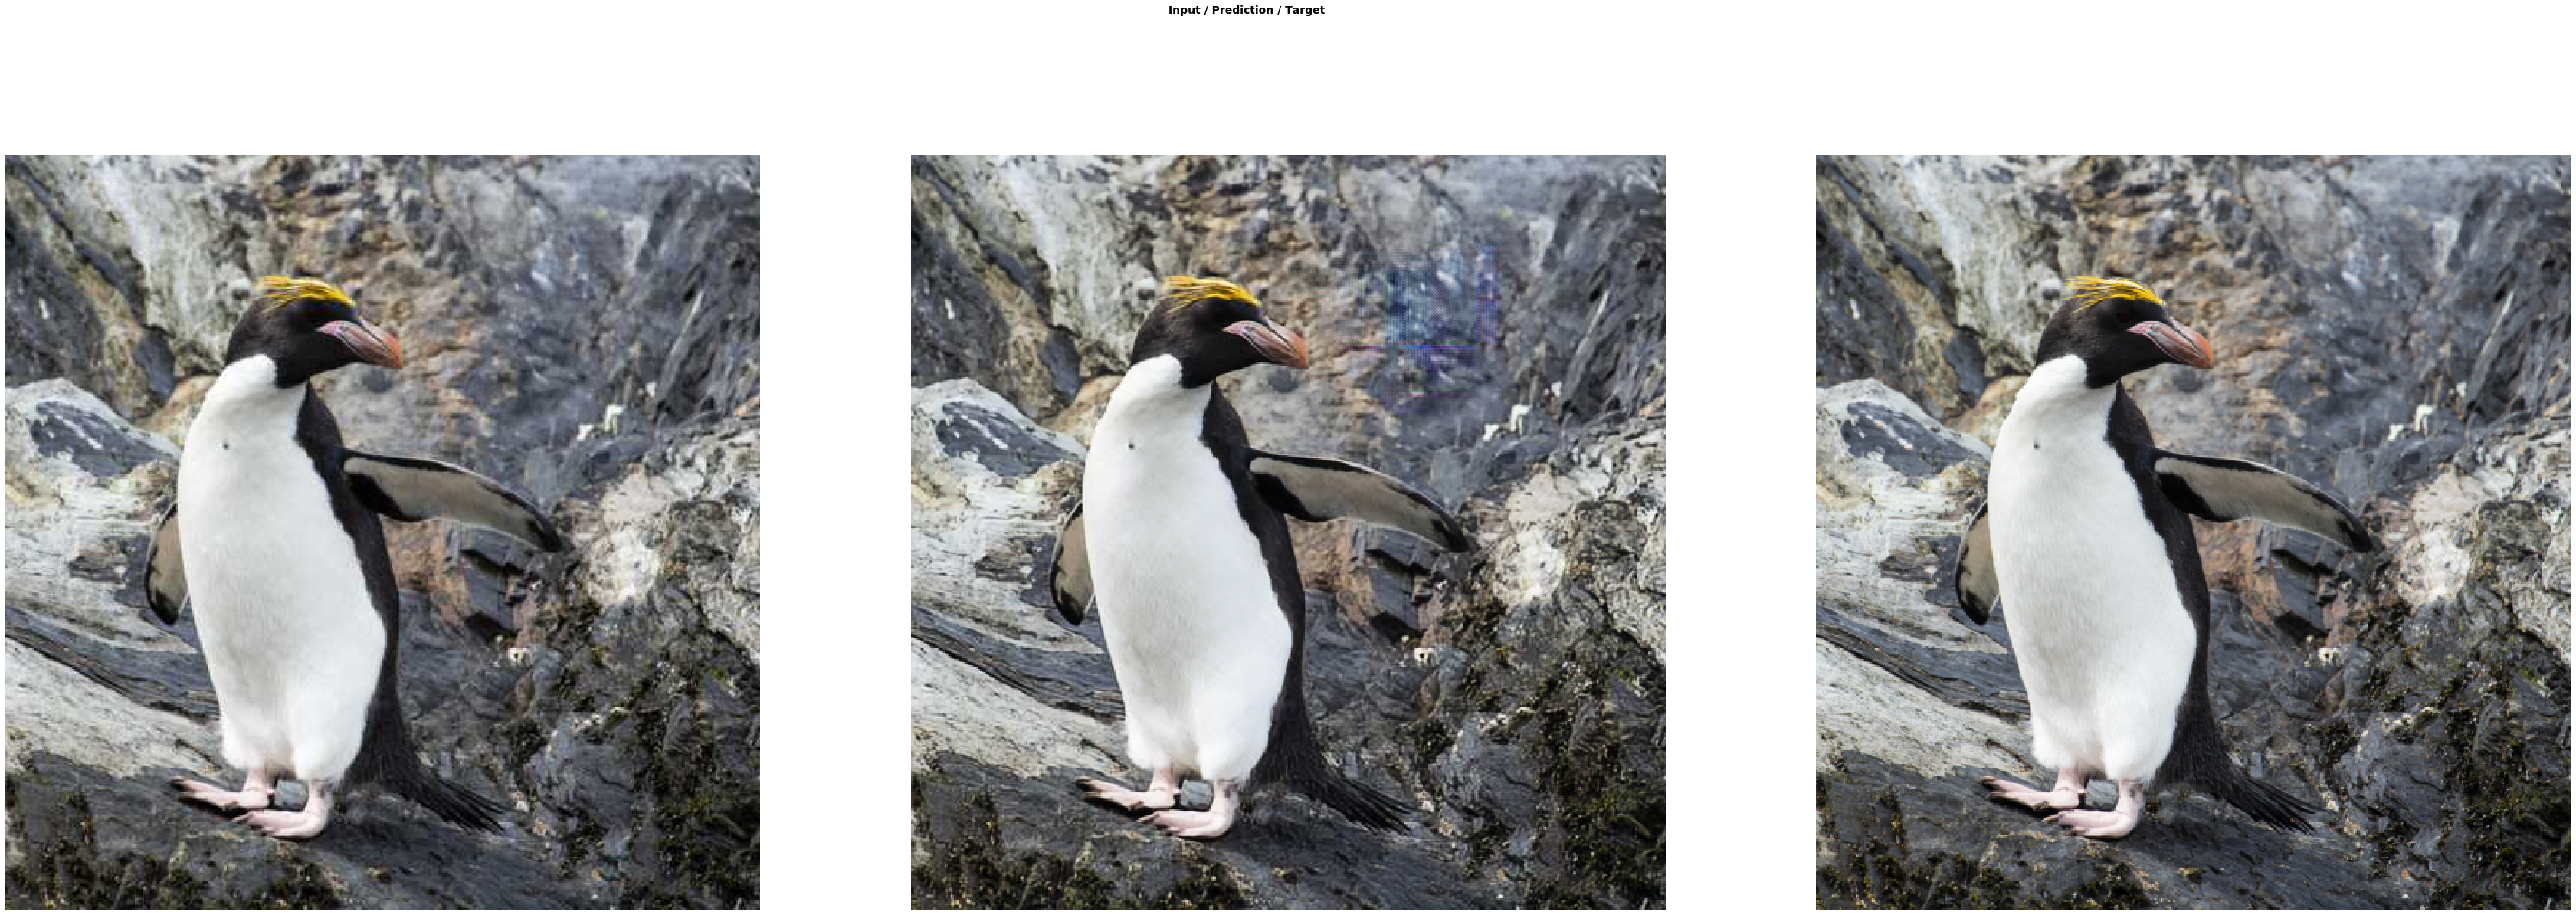

In [16]:
do_fit(learn_gen, 1, gen_name+"_512px_5", 1e-3)

# Test

In [ ]:
bs=1
sz=512
epochs = 1

In [ ]:
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
size=( 512, 680)

In [ ]:
data_1k = (ImageImageList.from_folder(path_lowRes_512, presort=True).split_by_idxs(
            train_idx=list(range(0, 800)), valid_idx=list(range(800, 900)))
          .label_from_func(lambda x: path_fullRes/x.name.replace(".jpg", ".png"))
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_1k.c = 3

In [ ]:
learn_gen.data = data_1k
learn_gen.freeze()
gc.collect()

In [ ]:
fn = data_1k.valid_dl.x.items[2]; fn

In [ ]:
img = open_image(fn); print(img.shape)
p,img_hr,b = learn_gen.predict(img)

In [ ]:
show_image(img, figsize=(15,15), interpolation='nearest');

In [ ]:
Image(img_hr).show(figsize=(15,15))